In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 20
lead_time = 6
filename = '../../../data/Arctic_Monthy_Mean_1979_2021.csv'
pcmciplus_features = ['LW_down', 'sst', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Reading the dataset
df = pd.read_csv(filename)
df.head()

,Date,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent
0,1/1/1979,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191
1,2/1/1979,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929
2,3/1/1979,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089
3,4/1/1979,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,273.126062,259.557456,989.314698,15561238
4,5/1/1979,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613


In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df = df.astype(float)                 # cast df to float
df = df[pcmciplus_features]
df.tail(len(df))

,LW_down,sst,sea_ice_extent
Date,,,
1979-01-01,186.687054,273.355237,15604191.0
1979-02-01,174.794571,273.121885,16378929.0
1979-03-01,190.741933,273.088099,16521089.0
1979-04-01,212.937925,273.126062,15561238.0
1979-05-01,253.690478,273.393551,14085613.0
...,...,...,...
2021-04-01,225.171796,273.470298,13840000.0
2021-05-01,260.956781,273.888627,12660000.0
2021-06-01,294.931709,275.245088,10710000.0


In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

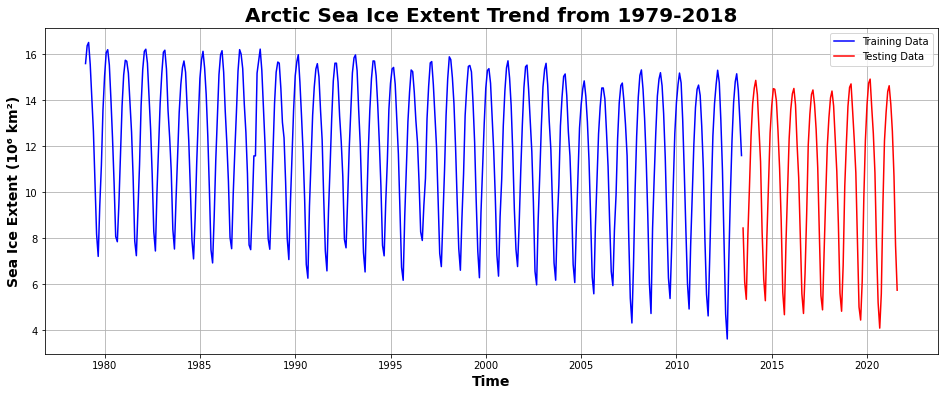

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            13248     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 20, 256)           296448    
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 20, 512)           1

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.5132 - mae: 0.5992 - mse: 0.5132

6/6 [==============================] - 20s 633ms/step - loss: 0.5132 - mae: 0.5992 - mse: 0.5132 - val_loss: 0.1573 - val_mae: 0.3450 - val_mse: 0.1573
Epoch 2/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0972 - mae: 0.2585 - mse: 0.0972

6/6 [==============================] - 0s 66ms/step - loss: 0.0991 - mae: 0.2626 - mse: 0.0991 - val_loss: 0.0780 - val_mae: 0.2396 - val_mse: 0.0780
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0720 - mae: 0.2207 - mse: 0.0720

6/6 [==============================] - 0s 54ms/step - loss: 0.0733 - mae: 0.2236 - mse: 0.0733 - val_loss: 0.0789 - val_mae: 0.2381 - val_mse: 0.0789
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0645 - mae: 0.2158 - mse: 0.0645

6/6 [==============================] - 0s 47ms/step - loss: 0.0645 - mae: 0.2162 - mse: 0.0645 - val_loss: 0.0780 - val_mae: 0.2389 - val_mse: 0.0780
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0623 - mae: 0.2080 - mse: 0.0623

6/6 [==============================] - 0s 46ms/step - loss: 0.0635 - mae: 0.2109 - mse: 0.0635 - val_loss: 0.0771 - val_mae: 0.2397 - val_mse: 0.0771
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0689 - mae: 0.2250 - mse: 0.0689

6/6 [==============================] - 0s 47ms/step - loss: 0.0667 - mae: 0.2194 - mse: 0.0667 - val_loss: 0.0871 - val_mae: 0.2347 - val_mse: 0.0871
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0626 - mae: 0.2093 - mse: 0.0626

6/6 [==============================] - 0s 47ms/step - loss: 0.0614 - mae: 0.2075 - mse: 0.0614 - val_loss: 0.0792 - val_mae: 0.2366 - val_mse: 0.0792
Epoch 8/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0624 - mae: 0.2144 - mse: 0.0624

6/6 [==============================] - 0s 46ms/step - loss: 0.0632 - mae: 0.2161 - mse: 0.0632 - val_loss: 0.0904 - val_mae: 0.2352 - val_mse: 0.0904
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0601 - mae: 0.2028 - mse: 0.0601

6/6 [==============================] - 0s 44ms/step - loss: 0.0615 - mae: 0.2053 - mse: 0.0615 - val_loss: 0.0771 - val_mae: 0.2366 - val_mse: 0.0771
Epoch 10/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0614 - mae: 0.2142 - mse: 0.0614

6/6 [==============================] - 0s 46ms/step - loss: 0.0621 - mae: 0.2145 - mse: 0.0621 - val_loss: 0.0800 - val_mae: 0.2295 - val_mse: 0.0800
Epoch 11/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0643 - mae: 0.2109 - mse: 0.0643

6/6 [==============================] - 0s 45ms/step - loss: 0.0643 - mae: 0.2114 - mse: 0.0643 - val_loss: 0.0914 - val_mae: 0.2344 - val_mse: 0.0914
Epoch 12/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0659 - mae: 0.2142 - mse: 0.0659

6/6 [==============================] - 0s 48ms/step - loss: 0.0651 - mae: 0.2128 - mse: 0.0651 - val_loss: 0.0841 - val_mae: 0.2599 - val_mse: 0.0841
Epoch 13/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0639 - mae: 0.2192 - mse: 0.0639

6/6 [==============================] - 0s 48ms/step - loss: 0.0627 - mae: 0.2164 - mse: 0.0627 - val_loss: 0.0957 - val_mae: 0.2375 - val_mse: 0.0957
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0614 - mae: 0.2067 - mse: 0.0614

6/6 [==============================] - 0s 47ms/step - loss: 0.0609 - mae: 0.2076 - mse: 0.0609 - val_loss: 0.0781 - val_mae: 0.2481 - val_mse: 0.0781
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0656 - mae: 0.2191 - mse: 0.0656

6/6 [==============================] - 0s 48ms/step - loss: 0.0657 - mae: 0.2197 - mse: 0.0657 - val_loss: 0.0820 - val_mae: 0.2358 - val_mse: 0.0820
Epoch 16/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0609 - mae: 0.2102 - mse: 0.0609

6/6 [==============================] - 0s 50ms/step - loss: 0.0612 - mae: 0.2108 - mse: 0.0612 - val_loss: 0.0770 - val_mae: 0.2406 - val_mse: 0.0770
Epoch 17/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0621 - mae: 0.2163 - mse: 0.0621

6/6 [==============================] - 0s 47ms/step - loss: 0.0614 - mae: 0.2146 - mse: 0.0614 - val_loss: 0.0789 - val_mae: 0.2379 - val_mse: 0.0789
Epoch 18/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0600 - mae: 0.2084 - mse: 0.0600

6/6 [==============================] - 0s 46ms/step - loss: 0.0587 - mae: 0.2052 - mse: 0.0587 - val_loss: 0.0779 - val_mae: 0.2386 - val_mse: 0.0779
Epoch 19/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0582 - mae: 0.2085 - mse: 0.0582

6/6 [==============================] - 0s 45ms/step - loss: 0.0584 - mae: 0.2094 - mse: 0.0584 - val_loss: 0.0784 - val_mae: 0.2380 - val_mse: 0.0784
Epoch 20/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0593 - mae: 0.2052 - mse: 0.0593

6/6 [==============================] - 0s 46ms/step - loss: 0.0598 - mae: 0.2083 - mse: 0.0598 - val_loss: 0.0787 - val_mae: 0.2376 - val_mse: 0.0787
Epoch 21/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0621 - mae: 0.2152 - mse: 0.0621

6/6 [==============================] - 0s 45ms/step - loss: 0.0610 - mae: 0.2130 - mse: 0.0610 - val_loss: 0.0812 - val_mae: 0.2357 - val_mse: 0.0812
Epoch 22/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0593 - mae: 0.2087 - mse: 0.0593

6/6 [==============================] - 0s 48ms/step - loss: 0.0601 - mae: 0.2098 - mse: 0.0601 - val_loss: 0.0778 - val_mae: 0.2380 - val_mse: 0.0778
Epoch 23/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0568 - mae: 0.2077 - mse: 0.0568

6/6 [==============================] - 0s 47ms/step - loss: 0.0568 - mae: 0.2070 - mse: 0.0568 - val_loss: 0.0802 - val_mae: 0.2358 - val_mse: 0.0802
Epoch 24/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0591 - mae: 0.2081 - mse: 0.0591

6/6 [==============================] - 0s 47ms/step - loss: 0.0605 - mae: 0.2101 - mse: 0.0605 - val_loss: 0.0771 - val_mae: 0.2378 - val_mse: 0.0771
Epoch 25/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0654 - mae: 0.2246 - mse: 0.0654

6/6 [==============================] - 0s 47ms/step - loss: 0.0632 - mae: 0.2195 - mse: 0.0632 - val_loss: 0.0805 - val_mae: 0.2343 - val_mse: 0.0805
Epoch 26/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0610 - mae: 0.2040 - mse: 0.0610

6/6 [==============================] - 0s 45ms/step - loss: 0.0602 - mae: 0.2038 - mse: 0.0602 - val_loss: 0.0787 - val_mae: 0.2343 - val_mse: 0.0787
Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0576 - mae: 0.2069 - mse: 0.0576

6/6 [==============================] - 0s 47ms/step - loss: 0.0572 - mae: 0.2053 - mse: 0.0572 - val_loss: 0.0724 - val_mae: 0.2349 - val_mse: 0.0724
Epoch 28/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0546 - mae: 0.1997 - mse: 0.0546

6/6 [==============================] - 0s 47ms/step - loss: 0.0543 - mae: 0.1987 - mse: 0.0543 - val_loss: 0.0862 - val_mae: 0.2295 - val_mse: 0.0862
Epoch 29/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0634 - mae: 0.2109 - mse: 0.0634

6/6 [==============================] - 0s 45ms/step - loss: 0.0627 - mae: 0.2099 - mse: 0.0627 - val_loss: 0.0769 - val_mae: 0.2465 - val_mse: 0.0769
Epoch 30/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0616 - mae: 0.2150 - mse: 0.0616

6/6 [==============================] - 0s 48ms/step - loss: 0.0609 - mae: 0.2135 - mse: 0.0609 - val_loss: 0.0825 - val_mae: 0.2340 - val_mse: 0.0825
Epoch 31/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0605 - mae: 0.2060 - mse: 0.0605

6/6 [==============================] - 0s 48ms/step - loss: 0.0596 - mae: 0.2052 - mse: 0.0596 - val_loss: 0.0756 - val_mae: 0.2377 - val_mse: 0.0756
Epoch 32/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0582 - mae: 0.2102 - mse: 0.0582

6/6 [==============================] - 0s 46ms/step - loss: 0.0586 - mae: 0.2106 - mse: 0.0586 - val_loss: 0.0809 - val_mae: 0.2319 - val_mse: 0.0809
Epoch 33/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0577 - mae: 0.2070 - mse: 0.0577

6/6 [==============================] - 0s 48ms/step - loss: 0.0571 - mae: 0.2065 - mse: 0.0571 - val_loss: 0.0755 - val_mae: 0.2259 - val_mse: 0.0755
Epoch 34/100
6/6 [==============================] - ETA: 0s - loss: 0.0631 - mae: 0.2104 - mse: 0.0631

6/6 [==============================] - 0s 52ms/step - loss: 0.0631 - mae: 0.2104 - mse: 0.0631 - val_loss: 0.0948 - val_mae: 0.2332 - val_mse: 0.0948
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0622 - mae: 0.2046 - mse: 0.0622

6/6 [==============================] - 0s 48ms/step - loss: 0.0630 - mae: 0.2076 - mse: 0.0630 - val_loss: 0.0764 - val_mae: 0.2424 - val_mse: 0.0764
Epoch 36/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0623 - mae: 0.2148 - mse: 0.0623

6/6 [==============================] - 0s 48ms/step - loss: 0.0613 - mae: 0.2119 - mse: 0.0613 - val_loss: 0.0817 - val_mae: 0.2349 - val_mse: 0.0817
Epoch 37/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0581 - mae: 0.2074 - mse: 0.0581

6/6 [==============================] - 0s 47ms/step - loss: 0.0585 - mae: 0.2076 - mse: 0.0585 - val_loss: 0.0757 - val_mae: 0.2382 - val_mse: 0.0757
Epoch 38/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0592 - mae: 0.2093 - mse: 0.0592

6/6 [==============================] - 0s 47ms/step - loss: 0.0592 - mae: 0.2088 - mse: 0.0592 - val_loss: 0.0778 - val_mae: 0.2344 - val_mse: 0.0778
Epoch 39/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0571 - mae: 0.2047 - mse: 0.0571

6/6 [==============================] - 0s 47ms/step - loss: 0.0575 - mae: 0.2060 - mse: 0.0575 - val_loss: 0.0758 - val_mae: 0.2359 - val_mse: 0.0758
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0580 - mae: 0.2048 - mse: 0.0580

6/6 [==============================] - 0s 48ms/step - loss: 0.0576 - mae: 0.2039 - mse: 0.0576 - val_loss: 0.0725 - val_mae: 0.2325 - val_mse: 0.0725
Epoch 41/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0589 - mae: 0.2126 - mse: 0.0589

6/6 [==============================] - 0s 48ms/step - loss: 0.0579 - mae: 0.2101 - mse: 0.0579 - val_loss: 0.0759 - val_mae: 0.2213 - val_mse: 0.0759
Epoch 42/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0544 - mae: 0.1970 - mse: 0.0544

6/6 [==============================] - 0s 47ms/step - loss: 0.0542 - mae: 0.1958 - mse: 0.0542 - val_loss: 0.0597 - val_mae: 0.2179 - val_mse: 0.0597
Epoch 43/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0450 - mae: 0.1795 - mse: 0.0450

6/6 [==============================] - 0s 46ms/step - loss: 0.0441 - mae: 0.1778 - mse: 0.0441 - val_loss: 0.0606 - val_mae: 0.2042 - val_mse: 0.0606
Epoch 44/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0345 - mae: 0.1511 - mse: 0.0345

6/6 [==============================] - 0s 48ms/step - loss: 0.0336 - mae: 0.1497 - mse: 0.0336 - val_loss: 0.0567 - val_mae: 0.1814 - val_mse: 0.0567
Epoch 45/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0334 - mae: 0.1490 - mse: 0.0334

6/6 [==============================] - 0s 49ms/step - loss: 0.0322 - mae: 0.1462 - mse: 0.0322 - val_loss: 0.0218 - val_mae: 0.1214 - val_mse: 0.0218
Epoch 46/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0184 - mae: 0.1129 - mse: 0.0184

6/6 [==============================] - 0s 45ms/step - loss: 0.0183 - mae: 0.1121 - mse: 0.0183 - val_loss: 0.0192 - val_mae: 0.1060 - val_mse: 0.0192
Epoch 47/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0199 - mae: 0.1137 - mse: 0.0199

6/6 [==============================] - 0s 49ms/step - loss: 0.0194 - mae: 0.1129 - mse: 0.0194 - val_loss: 0.0213 - val_mae: 0.1269 - val_mse: 0.0213
Epoch 48/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0215 - mae: 0.1239 - mse: 0.0215

6/6 [==============================] - 0s 46ms/step - loss: 0.0208 - mae: 0.1207 - mse: 0.0208 - val_loss: 0.0286 - val_mae: 0.1333 - val_mse: 0.0286
Epoch 49/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0232 - mae: 0.1263 - mse: 0.0232

6/6 [==============================] - 0s 49ms/step - loss: 0.0234 - mae: 0.1269 - mse: 0.0234 - val_loss: 0.0186 - val_mae: 0.1163 - val_mse: 0.0186
Epoch 50/100
6/6 [==============================] - ETA: 0s - loss: 0.0173 - mae: 0.1081 - mse: 0.0173

6/6 [==============================] - 0s 49ms/step - loss: 0.0173 - mae: 0.1081 - mse: 0.0173 - val_loss: 0.0106 - val_mae: 0.0839 - val_mse: 0.0106
Epoch 51/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0123 - mae: 0.0905 - mse: 0.0123

6/6 [==============================] - 0s 47ms/step - loss: 0.0120 - mae: 0.0884 - mse: 0.0120 - val_loss: 0.0167 - val_mae: 0.0950 - val_mse: 0.0167
Epoch 52/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0123 - mae: 0.0886 - mse: 0.0123

6/6 [==============================] - 0s 46ms/step - loss: 0.0117 - mae: 0.0862 - mse: 0.0117 - val_loss: 0.0101 - val_mae: 0.0732 - val_mse: 0.0101
Epoch 53/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0096 - mae: 0.0784 - mse: 0.0096

6/6 [==============================] - 0s 49ms/step - loss: 0.0094 - mae: 0.0773 - mse: 0.0094 - val_loss: 0.0057 - val_mae: 0.0570 - val_mse: 0.0057
Epoch 54/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0080 - mae: 0.0703 - mse: 0.0080

6/6 [==============================] - 0s 47ms/step - loss: 0.0085 - mae: 0.0724 - mse: 0.0085 - val_loss: 0.0069 - val_mae: 0.0607 - val_mse: 0.0069
Epoch 55/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0062 - mae: 0.0628 - mse: 0.0062

6/6 [==============================] - 0s 48ms/step - loss: 0.0069 - mae: 0.0659 - mse: 0.0069 - val_loss: 0.0056 - val_mae: 0.0606 - val_mse: 0.0056
Epoch 56/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0081 - mae: 0.0720 - mse: 0.0081

6/6 [==============================] - 0s 47ms/step - loss: 0.0079 - mae: 0.0714 - mse: 0.0079 - val_loss: 0.0051 - val_mae: 0.0498 - val_mse: 0.0051
Epoch 57/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0053 - mae: 0.0571 - mse: 0.0053

6/6 [==============================] - 0s 47ms/step - loss: 0.0052 - mae: 0.0567 - mse: 0.0052 - val_loss: 0.0033 - val_mae: 0.0437 - val_mse: 0.0033
Epoch 58/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0065 - mae: 0.0646 - mse: 0.0065

6/6 [==============================] - 0s 46ms/step - loss: 0.0065 - mae: 0.0643 - mse: 0.0065 - val_loss: 0.0036 - val_mae: 0.0450 - val_mse: 0.0036
Epoch 59/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0055 - mae: 0.0589 - mse: 0.0055

6/6 [==============================] - 0s 47ms/step - loss: 0.0056 - mae: 0.0600 - mse: 0.0056 - val_loss: 0.0038 - val_mae: 0.0452 - val_mse: 0.0038
Epoch 60/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0062 - mae: 0.0635 - mse: 0.0062

6/6 [==============================] - 0s 46ms/step - loss: 0.0061 - mae: 0.0630 - mse: 0.0061 - val_loss: 0.0146 - val_mae: 0.1079 - val_mse: 0.0146
Epoch 61/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0110 - mae: 0.0861 - mse: 0.0110

6/6 [==============================] - 0s 48ms/step - loss: 0.0109 - mae: 0.0853 - mse: 0.0109 - val_loss: 0.0047 - val_mae: 0.0521 - val_mse: 0.0047
Epoch 62/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0065 - mae: 0.0649 - mse: 0.0065

6/6 [==============================] - 0s 48ms/step - loss: 0.0066 - mae: 0.0651 - mse: 0.0066 - val_loss: 0.0049 - val_mae: 0.0534 - val_mse: 0.0049
Epoch 63/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0064 - mae: 0.0635 - mse: 0.0064

6/6 [==============================] - 0s 47ms/step - loss: 0.0065 - mae: 0.0635 - mse: 0.0065 - val_loss: 0.0036 - val_mae: 0.0457 - val_mse: 0.0036
Epoch 64/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0046 - mae: 0.0536 - mse: 0.0046

6/6 [==============================] - 0s 48ms/step - loss: 0.0049 - mae: 0.0550 - mse: 0.0049 - val_loss: 0.0028 - val_mae: 0.0383 - val_mse: 0.0028
Epoch 65/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0062 - mae: 0.0625 - mse: 0.0062

6/6 [==============================] - 0s 47ms/step - loss: 0.0060 - mae: 0.0620 - mse: 0.0060 - val_loss: 0.0064 - val_mae: 0.0527 - val_mse: 0.0064
Epoch 66/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0060 - mae: 0.0618 - mse: 0.0060

6/6 [==============================] - 0s 47ms/step - loss: 0.0060 - mae: 0.0619 - mse: 0.0060 - val_loss: 0.0027 - val_mae: 0.0401 - val_mse: 0.0027
Epoch 67/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0062 - mae: 0.0648 - mse: 0.0062

6/6 [==============================] - 0s 47ms/step - loss: 0.0065 - mae: 0.0661 - mse: 0.0065 - val_loss: 0.0088 - val_mae: 0.0805 - val_mse: 0.0088
Epoch 68/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0065 - mae: 0.0637 - mse: 0.0065

6/6 [==============================] - 0s 48ms/step - loss: 0.0066 - mae: 0.0646 - mse: 0.0066 - val_loss: 0.0036 - val_mae: 0.0482 - val_mse: 0.0036
Epoch 69/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0057 - mae: 0.0618 - mse: 0.0057

6/6 [==============================] - 0s 49ms/step - loss: 0.0057 - mae: 0.0619 - mse: 0.0057 - val_loss: 0.0042 - val_mae: 0.0546 - val_mse: 0.0042
Epoch 70/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0529 - mse: 0.0043

6/6 [==============================] - 0s 47ms/step - loss: 0.0043 - mae: 0.0526 - mse: 0.0043 - val_loss: 0.0021 - val_mae: 0.0371 - val_mse: 0.0021
Epoch 71/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0547 - mse: 0.0047

6/6 [==============================] - 0s 45ms/step - loss: 0.0046 - mae: 0.0539 - mse: 0.0046 - val_loss: 0.0021 - val_mae: 0.0355 - val_mse: 0.0021
Epoch 72/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0046 - mae: 0.0542 - mse: 0.0046

6/6 [==============================] - 0s 46ms/step - loss: 0.0045 - mae: 0.0536 - mse: 0.0045 - val_loss: 0.0026 - val_mae: 0.0382 - val_mse: 0.0026
Epoch 73/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0048 - mae: 0.0528 - mse: 0.0048

6/6 [==============================] - 0s 48ms/step - loss: 0.0047 - mae: 0.0531 - mse: 0.0047 - val_loss: 0.0020 - val_mae: 0.0338 - val_mse: 0.0020
Epoch 74/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0046 - mae: 0.0526 - mse: 0.0046

6/6 [==============================] - 0s 48ms/step - loss: 0.0045 - mae: 0.0523 - mse: 0.0045 - val_loss: 0.0029 - val_mae: 0.0428 - val_mse: 0.0029
Epoch 75/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0496 - mse: 0.0038

6/6 [==============================] - 0s 49ms/step - loss: 0.0037 - mae: 0.0492 - mse: 0.0037 - val_loss: 0.0032 - val_mae: 0.0467 - val_mse: 0.0032
Epoch 76/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0483 - mse: 0.0038

6/6 [==============================] - 0s 48ms/step - loss: 0.0037 - mae: 0.0476 - mse: 0.0037 - val_loss: 0.0026 - val_mae: 0.0423 - val_mse: 0.0026
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0045 - mae: 0.0519 - mse: 0.0045

6/6 [==============================] - 0s 46ms/step - loss: 0.0044 - mae: 0.0515 - mse: 0.0044 - val_loss: 0.0046 - val_mae: 0.0602 - val_mse: 0.0046
Epoch 78/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0516 - mse: 0.0043

6/6 [==============================] - 0s 47ms/step - loss: 0.0043 - mae: 0.0518 - mse: 0.0043 - val_loss: 0.0060 - val_mae: 0.0688 - val_mse: 0.0060
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0054 - mae: 0.0556 - mse: 0.0054

6/6 [==============================] - 0s 48ms/step - loss: 0.0052 - mae: 0.0549 - mse: 0.0052 - val_loss: 0.0024 - val_mae: 0.0396 - val_mse: 0.0024
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0481 - mse: 0.0036

6/6 [==============================] - 0s 47ms/step - loss: 0.0036 - mae: 0.0482 - mse: 0.0036 - val_loss: 0.0024 - val_mae: 0.0384 - val_mse: 0.0024
Epoch 81/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0485 - mse: 0.0039

6/6 [==============================] - 0s 47ms/step - loss: 0.0039 - mae: 0.0491 - mse: 0.0039 - val_loss: 0.0031 - val_mae: 0.0407 - val_mse: 0.0031
Epoch 82/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0496 - mse: 0.0038

6/6 [==============================] - 0s 48ms/step - loss: 0.0038 - mae: 0.0493 - mse: 0.0038 - val_loss: 0.0023 - val_mae: 0.0381 - val_mse: 0.0023
Epoch 83/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0502 - mse: 0.0039

6/6 [==============================] - 0s 48ms/step - loss: 0.0040 - mae: 0.0511 - mse: 0.0040 - val_loss: 0.0015 - val_mae: 0.0305 - val_mse: 0.0015
Epoch 84/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0478 - mse: 0.0036

6/6 [==============================] - 0s 47ms/step - loss: 0.0037 - mae: 0.0490 - mse: 0.0037 - val_loss: 0.0018 - val_mae: 0.0339 - val_mse: 0.0018
Epoch 85/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0049 - mae: 0.0578 - mse: 0.0049

6/6 [==============================] - 0s 48ms/step - loss: 0.0048 - mae: 0.0572 - mse: 0.0048 - val_loss: 0.0015 - val_mae: 0.0303 - val_mse: 0.0015
Epoch 86/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0510 - mse: 0.0043

6/6 [==============================] - 0s 46ms/step - loss: 0.0043 - mae: 0.0516 - mse: 0.0043 - val_loss: 0.0043 - val_mae: 0.0543 - val_mse: 0.0043
Epoch 87/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0048 - mae: 0.0555 - mse: 0.0048

6/6 [==============================] - 0s 49ms/step - loss: 0.0047 - mae: 0.0545 - mse: 0.0047 - val_loss: 0.0050 - val_mae: 0.0614 - val_mse: 0.0050
Epoch 88/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0052 - mae: 0.0572 - mse: 0.0052

6/6 [==============================] - 0s 46ms/step - loss: 0.0050 - mae: 0.0561 - mse: 0.0050 - val_loss: 0.0027 - val_mae: 0.0433 - val_mse: 0.0027
Epoch 89/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0492 - mse: 0.0040

6/6 [==============================] - 0s 48ms/step - loss: 0.0040 - mae: 0.0492 - mse: 0.0040 - val_loss: 0.0020 - val_mae: 0.0331 - val_mse: 0.0020
Epoch 90/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0473 - mse: 0.0036

6/6 [==============================] - 0s 46ms/step - loss: 0.0036 - mae: 0.0473 - mse: 0.0036 - val_loss: 0.0015 - val_mae: 0.0297 - val_mse: 0.0015
Epoch 91/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0037 - mae: 0.0486 - mse: 0.0037

6/6 [==============================] - 0s 47ms/step - loss: 0.0037 - mae: 0.0486 - mse: 0.0037 - val_loss: 0.0011 - val_mae: 0.0256 - val_mse: 0.0011
Epoch 92/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0037 - mae: 0.0479 - mse: 0.0037

6/6 [==============================] - 0s 47ms/step - loss: 0.0036 - mae: 0.0473 - mse: 0.0036 - val_loss: 0.0019 - val_mae: 0.0364 - val_mse: 0.0019
Epoch 93/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0485 - mse: 0.0040

6/6 [==============================] - 0s 49ms/step - loss: 0.0041 - mae: 0.0485 - mse: 0.0041 - val_loss: 0.0035 - val_mae: 0.0469 - val_mse: 0.0035
Epoch 94/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0510 - mse: 0.0038

6/6 [==============================] - 0s 48ms/step - loss: 0.0037 - mae: 0.0500 - mse: 0.0037 - val_loss: 0.0022 - val_mae: 0.0356 - val_mse: 0.0022
Epoch 95/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0499 - mse: 0.0038

6/6 [==============================] - 0s 48ms/step - loss: 0.0037 - mae: 0.0491 - mse: 0.0037 - val_loss: 0.0011 - val_mae: 0.0241 - val_mse: 0.0011
Epoch 96/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0503 - mse: 0.0039

6/6 [==============================] - 0s 50ms/step - loss: 0.0038 - mae: 0.0491 - mse: 0.0038 - val_loss: 0.0034 - val_mae: 0.0437 - val_mse: 0.0034
Epoch 97/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0454 - mse: 0.0032

6/6 [==============================] - 0s 48ms/step - loss: 0.0032 - mae: 0.0451 - mse: 0.0032 - val_loss: 0.0025 - val_mae: 0.0390 - val_mse: 0.0025
Epoch 98/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0437 - mse: 0.0029

6/6 [==============================] - 0s 47ms/step - loss: 0.0029 - mae: 0.0437 - mse: 0.0029 - val_loss: 0.0015 - val_mae: 0.0307 - val_mse: 0.0015
Epoch 99/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0465 - mse: 0.0034

6/6 [==============================] - 0s 48ms/step - loss: 0.0034 - mae: 0.0465 - mse: 0.0034 - val_loss: 0.0014 - val_mae: 0.0295 - val_mse: 0.0014
Epoch 100/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0456 - mse: 0.0032

6/6 [==============================] - 0s 45ms/step - loss: 0.0034 - mae: 0.0467 - mse: 0.0034 - val_loss: 0.0041 - val_mae: 0.0556 - val_mse: 0.0041


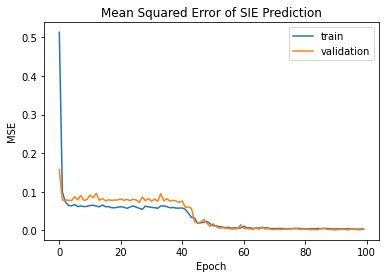

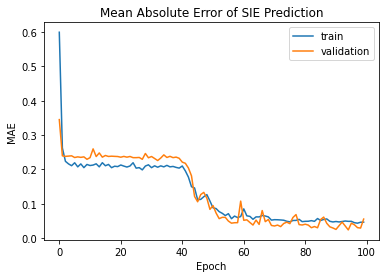

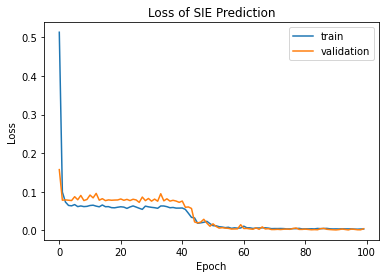

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

4/4 [==============================] - 2s 20ms/step


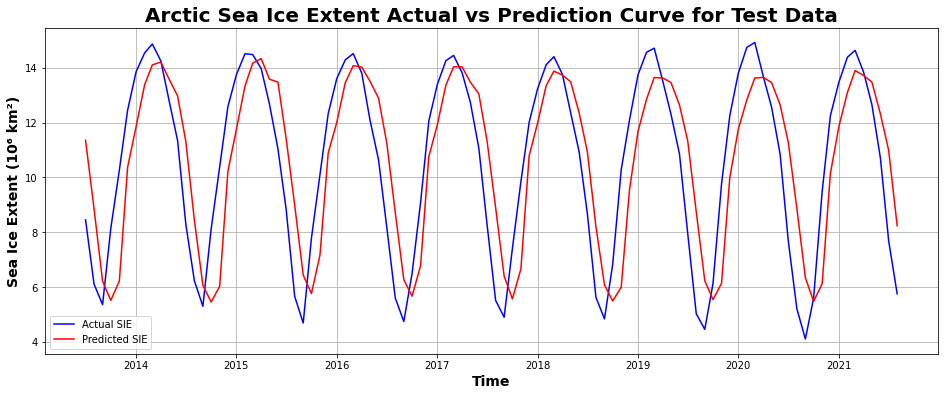

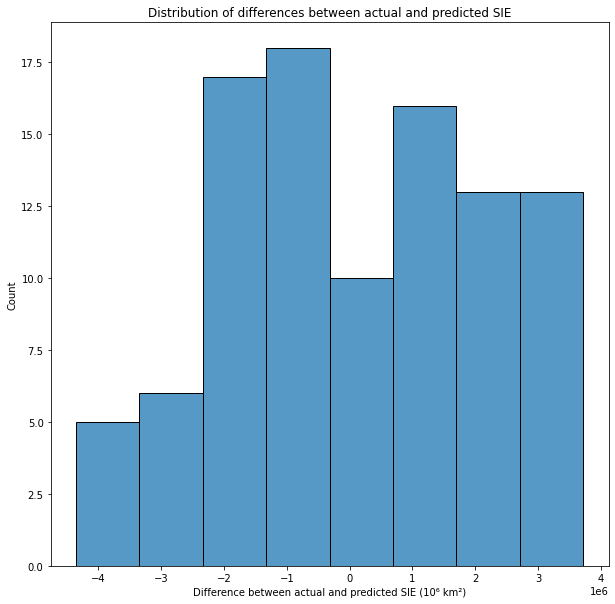

MSE :  4336049660675.9233 (10⁶ km²)
MSPE : 7.274 %
RMSE :  2082318.3379771507 (10⁶ km²)
RMSPE : 26.971 %
MAE :  1783790.8979591837 (10⁶ km²)
MAPE :  20.094 %
R2 :  52.349


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", round(mspe,3), "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", round(rmspe,3), "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", round(mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100,3), "%")
print("R2 : ", round(r2_score(predictions['predicted'].values, predictions['actual'].values)*100,3))

In [14]:
# while True:pass